# Evaluation

This notebook includes various evaluation metrics of the trained met-ml model. 

In [1]:
%load_ext lab_black

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.distributed import Client
import seaborn as sns

from sklearn.metrics import explained_variance_score, r2_score
import tensorflow as tf
from tensorflow.keras.models import load_model

from joblib import load, dump

from met_ml.train.fluxnet_etl import make_lookback
from met_ml.train.models import transform_df

train_vars = ["P", "t_min", "t_max", "t", "lat", "elev"]
target_vars = ["SW_IN_F", "LW_IN_F", "PA_F", "RH"]
lookback = 90

In [46]:
# load fitted transformers and model
fluxnet_df = pd.read_csv(
    "../data/etl/fluxnet.csv",
    index_col=["Unnamed: 0", "TIMESTAMP_START"],
    parse_dates=["TIMESTAMP_START"],
)
meta = pd.read_csv("../data/etl/meta.csv", index_col=0)

test_meta = pd.read_csv("../data/etl/test_meta.csv", index_col=0)

trans = load("../data/etl/fluxnet_all_transformers.joblib")

models = {
    "1_layer_lstm": load_model("./best_1_layer_lstm.h5", compile=False),
    "2_layer_lstm": load_model("./best_2_layer_lstm.h5", compile=False),
    "3_layer_lstm": load_model("./best_3_layer_lstm.h5", compile=False),
    "3_layer_lstm_wide": load_model("./best_3_layer_lstm_wide.h5", compile=False),
}

In [37]:
df_trans = transform_df(trans, fluxnet_df)

In [38]:
df_trans.head()

P     t_min     t_max   SW_IN_F   LW_IN_F      PA_F  \
       TIMESTAMP_START                                                          
AR-SLu 2009-01-01       0.0  1.128932  0.690825  0.183470  0.762338  0.722481   
       2009-01-02       0.0  1.027457  0.936208  0.590219  0.733104  0.730062   
       2009-01-03       0.0  0.967795  1.247784  0.793757  0.676937  0.731395   
       2009-01-04       0.0  1.289733  1.502405  0.951432  0.654861  0.721926   
       2009-01-05       0.0  1.397325  1.412009  0.709380  0.728502  0.713997   

                        RH         t       lat      elev  
       TIMESTAMP_START                                    
AR-SLu 2009-01-01      NaN  1.000000 -0.551425  0.100129  
       2009-01-02      NaN  0.999852 -0.551425  0.100129  
       2009-01-03      NaN  0.999408 -0.551425  0.100129  
       2009-01-04      NaN  0.998669 -0.551425  0.100129  
       2009-01-05      NaN  0.997634 -0.551425  0.100129

In [14]:
def inverse_transform(transformers, df):
    out = pd.DataFrame(index=df.index)
    for key in df:
        out[key] = transformers[key].inverse_transform(df[[key]])
    return out

In [47]:
eval_data = {}

for name in test_meta.index.values:  # only predicting val data sites
    print(name)
    xdf = df_trans.loc[name, train_vars]
    x = make_lookback(xdf, lookback)
    for modname, model in models.items():
        with tf.device("/GPU:0"):
            predicted = pd.DataFrame(
                model.predict(x.values),
                index=xdf.index[lookback - 1:],
                columns=target_vars,
            )
        for i, key in enumerate(target_vars):
            eval_data[(modname, name)] = inverse_transform(trans, predicted)

AU-Wac
AU-Ync
AU-Gin
AU-TTE
AU-Dry
AU-Fog
GH-Ank
SN-Dhr
CN-Dan
US-SRC
US-ARc
US-AR2
CN-HaM
US-Tw1
US-Blo
IT-Noe
US-GLE
IT-Cp2
CN-Du2
IT-Ro2
CA-TP1
IT-SR2
US-Me5
FR-LBr
IT-Isp
IT-MBo
US-Wi0
US-Wi2
CH-Fru
CH-Lae
CZ-wet
BE-Vie
DE-Gri
DE-Lnf
DE-Akm
CA-SF1
CA-NS1
RU-Fyo
FI-Hyy
FI-Sod
US-Atq
DK-ZaF


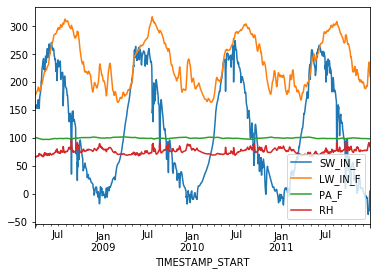

In [48]:
eval_data[(modname, name)].plot()

In [30]:
bench_data = {}
# var_list = ['', 'shortwave', 'longwave']
for name in eval_data.keys():
    fname = f"../data/metsim/metsim_{name}_DD.csv"
    try:
        df = pd.read_csv(fname, parse_dates=True, index_col=0)
        bench_data[name] = df
    except:
        print(fname)

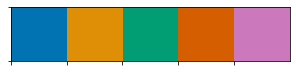

In [52]:
colors = sns.color_palette("colorblind", n_colors=1 + len(models))
sns.palplot(colors)

In [40]:
fluxnet_df.loc[name, fluxn_var].iloc[last_n:]

TIMESTAMP_START
2008-01-02    276.817646
2008-01-03    264.982188
2008-01-04    268.161146
2008-01-05    264.845792
2008-01-06    269.092729
                 ...    
2008-12-27    224.604167
2008-12-28    277.541667
2008-12-29    208.395833
2008-12-30    172.847229
2008-12-31    223.947917
Name: SW_IN_F, Length: 365, dtype: float64

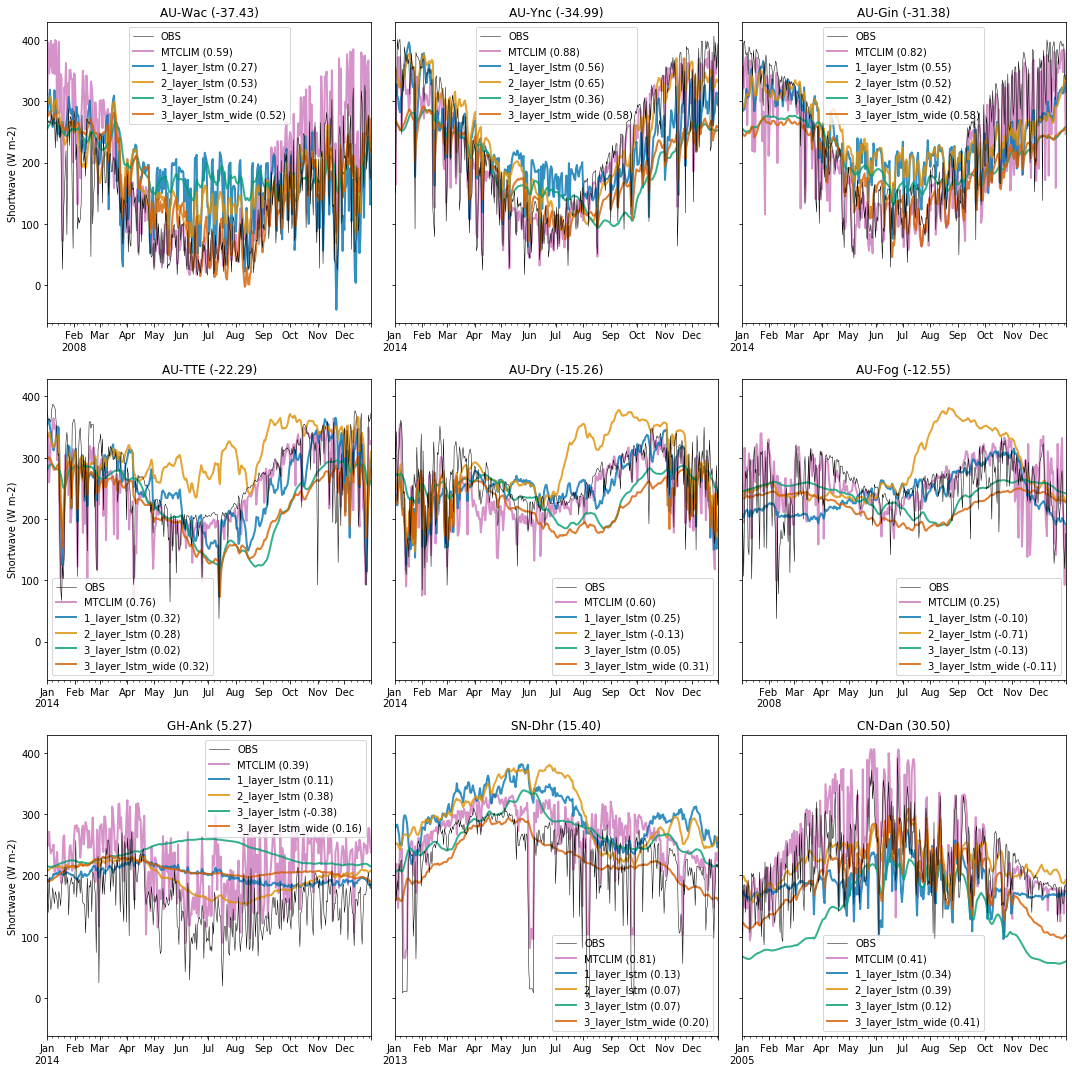

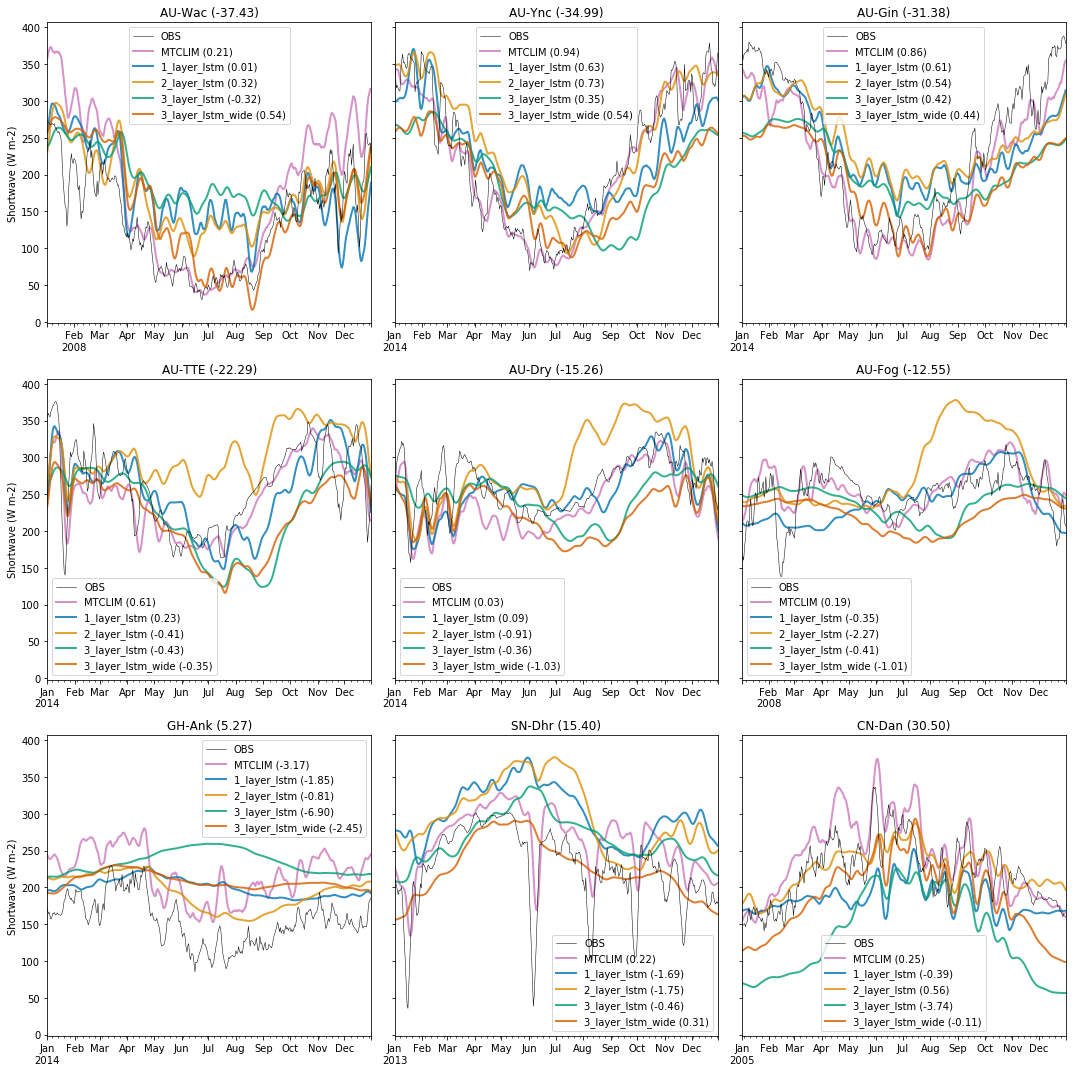

In [62]:
last_n = -365 * 1

fluxn_var = "SW_IN_F"
bench_var = "shortwave"

style = {
    "OBS": dict(c="k", lw=0.5, zorder=10),
    "MTCLIM": dict(c=colors[-1], lw=2, alpha=0.8),
}
for i, modname in enumerate(models):
    style[modname] = dict(c=colors[i], lw=2, alpha=0.8)


fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=True)

for ax, (name, site_meta) in zip(axes.flat, test_meta.iterrows()):
    obs_series = fluxnet_df.loc[name, fluxn_var].iloc[last_n:]
    obs_series.plot(label="OBS", ax=ax, **style["OBS"])

    mod_data = [("MTCLIM", bench_data[name][bench_var])]
    for modname in models:
        mod_data.append((modname, eval_data[modname, name][fluxn_var]))

    for kind, series in mod_data:
        data = series.iloc[last_n:]
        skill = explained_variance_score(obs_series.values, data.values)
        data.plot(ax=ax, label=f"{kind} ({skill:0.2f})", **style[kind])
    ax.legend()
    ax.set_xlabel("")
    lat = site_meta["lat"]
    ax.set_title(f"{name} ({lat:.2f})")

for ax in axes[:, 0]:
    ax.set_ylabel("Shortwave (W m-2)")

fig.tight_layout()
# fig.savefig("results_daily.png", dpi=300)
plt.show()
plt.close("all")

rolling = 7
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=True)

for ax, (name, site_meta) in zip(axes.flat, test_meta.iterrows()):
    obs_series = fluxnet_df.loc[name, fluxn_var].rolling(rolling).mean().iloc[last_n:]
    obs_series.plot(label="OBS", ax=ax, **style["OBS"])

    mod_data = [("MTCLIM", bench_data[name][bench_var])]
    for modname in models:
        mod_data.append((modname, eval_data[modname, name][fluxn_var]))

    for kind, series in mod_data:
        data = series.rolling(rolling).mean().rolling(rolling).mean().iloc[last_n:]
        skill = r2_score(obs_series.values, data.values)
        data.plot(ax=ax, label=f"{kind} ({skill:0.2f})", **style[kind])
    ax.legend()
    ax.set_xlabel("")
    lat = site_meta["lat"]
    ax.set_title(f"{name} ({lat:.2f})")

for ax in axes[:, 0]:
    ax.set_ylabel("Shortwave (W m-2)")

fig.tight_layout()
# fig.savefig("results_daily_rolling.png", dpi=300)
plt.show()
plt.close("all")

US-Atq


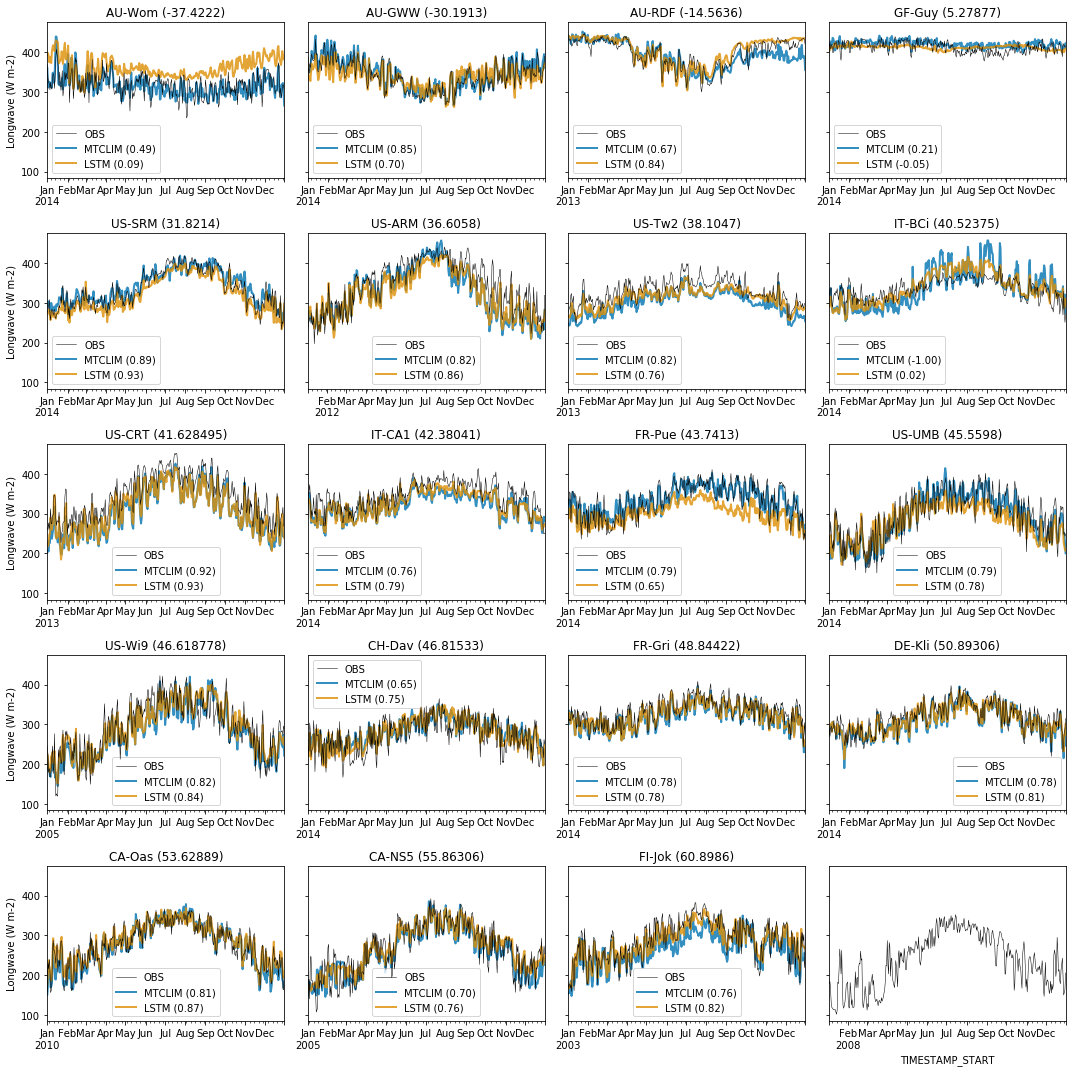

US-Atq


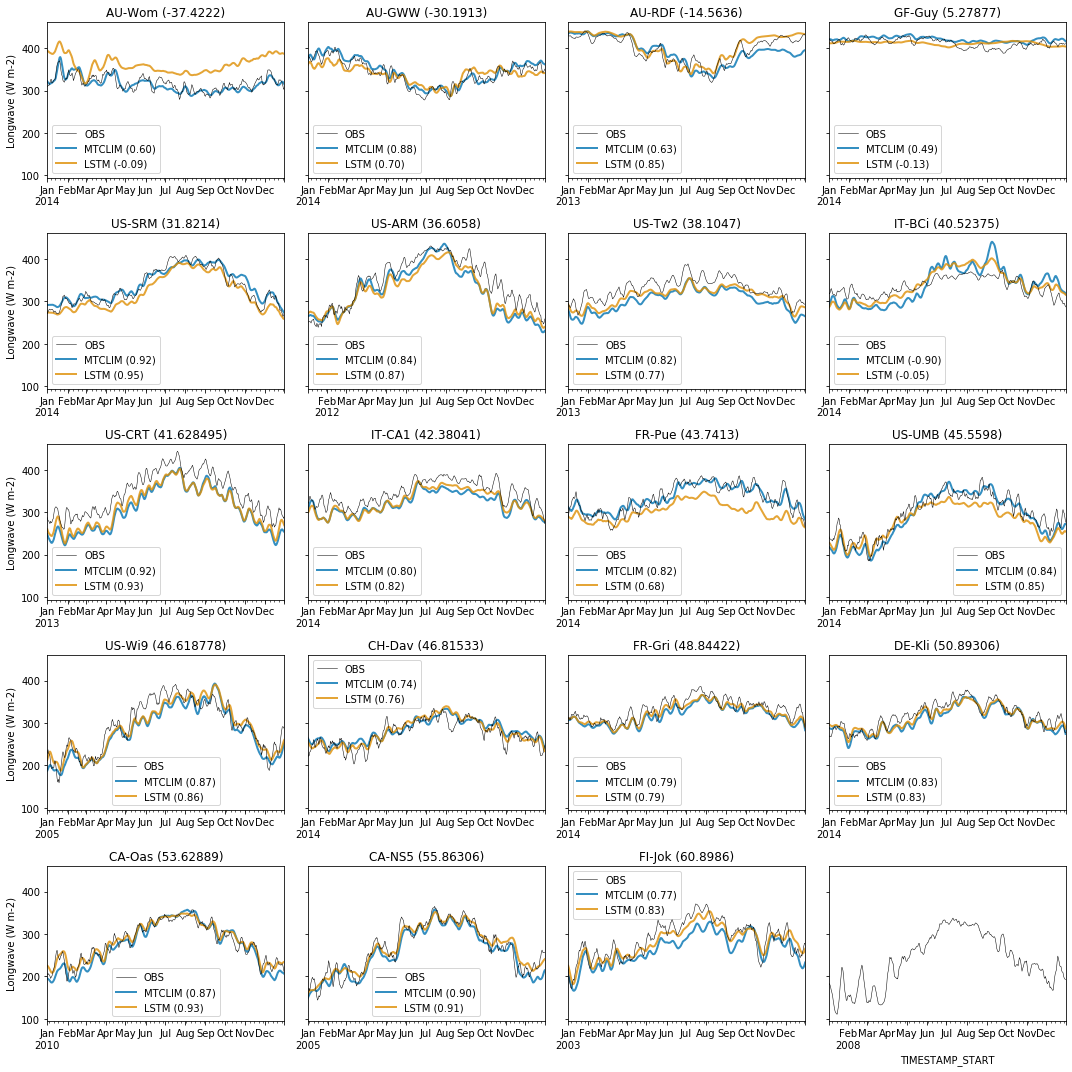

In [21]:
last_n = -365*1

fluxn_var = 'LW_IN_F'
bench_var = 'longwave'

style = {'OBS': dict(c='k', lw=0.5, zorder=10),
         'MTCLIM': dict(c=colors[0], lw=2, alpha=0.8),
         'LSTM': dict(c=colors[1], lw=2, alpha=0.8)}

fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=False, sharey=True)

for ax, (name, site_meta) in zip(axes.flat, test_meta.iterrows()):
    obs_series = obs_data[name][fluxn_var].iloc[last_n:]
    obs_series.plot(label='OBS', ax=ax, **style['OBS'])
    try:
        for kind, series in [('MTCLIM', bench_data[name][bench_var]), ('LSTM', eval_data[name][fluxn_var])]:
            data = series.iloc[last_n:]
            skill = explained_variance_score(obs_series.values, data.values)
            data.plot(ax=ax, label=f'{kind} ({skill:0.2f})', **style[kind])
        ax.legend()
        ax.set_xlabel('')
        lat = site_meta['lat']
        ax.set_title(f'{name} ({lat})')
    except:
        print(f'{name}')
    
for ax in axes[:, 0]:
    ax.set_ylabel('Longwave (W m-2)')
    
fig.tight_layout()
fig.savefig('results_daily.png', dpi=300)
plt.show()
plt.close('all')

rolling = 7
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=False, sharey=True)

for ax, (name, site_meta) in zip(axes.flat, test_meta.iterrows()):
    obs_series = obs_data[name][fluxn_var].rolling(rolling).mean().iloc[last_n:]
    obs_series.plot(label='OBS', ax=ax, **style['OBS'])
    try:
        for kind, series in [('MTCLIM', bench_data[name][bench_var]), ('LSTM', eval_data[name][fluxn_var])]:
            data = series.rolling(rolling).mean().rolling(rolling).mean().iloc[last_n:]
            skill = explained_variance_score(obs_series.values, data.values)
            data.plot(ax=ax, label=f'{kind} ({skill:0.2f})', **style[kind])
        ax.legend()
        ax.set_xlabel('')
        lat = site_meta['lat']
        ax.set_title(f'{name} ({lat})')
    except:
        print(f'{name}')
for ax in axes[:, 0]:
    ax.set_ylabel('Longwave (W m-2)')
    
fig.tight_layout()
fig.savefig('results_daily_rolling.png', dpi=300)
plt.show()
plt.close('all')

US-Atq


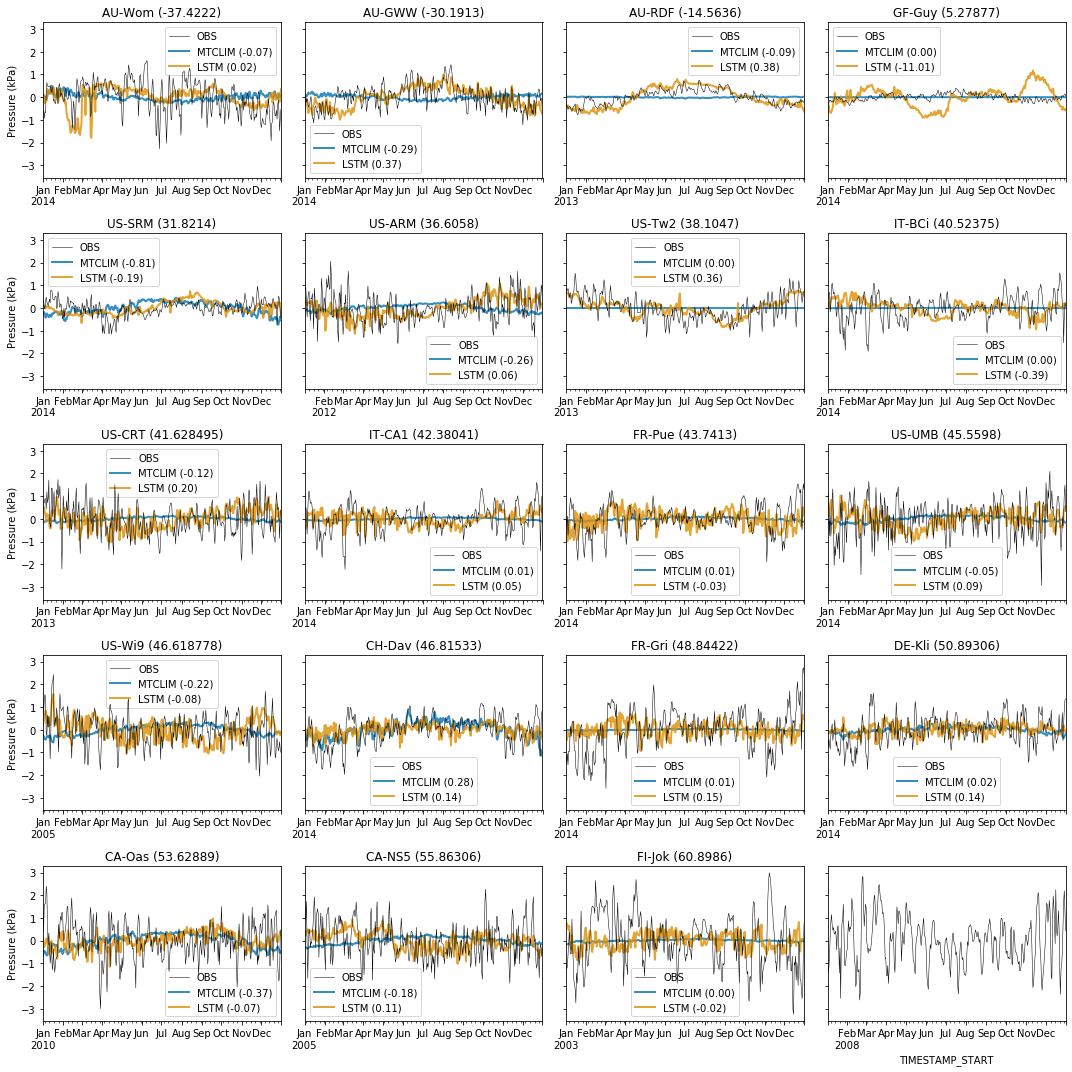

In [123]:
last_n = -365*1

fluxn_var = 'PA_F'
bench_var = 'air_pressure'

style = {'OBS': dict(c='k', lw=0.5, zorder=10),
         'MTCLIM': dict(c=colors[0], lw=2, alpha=0.8),
         'LSTM': dict(c=colors[1], lw=2, alpha=0.8)}

# fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=False, sharey=False)

# for ax, (name, site_meta) in zip(axes.flat, test_meta.iterrows()):
#     obs_series = obs_data[name][fluxn_var].iloc[last_n:]
#     obs_series.plot(label='OBS', ax=ax, **style['OBS'])
#     try:
#         for kind, series in [('MTCLIM', bench_data[name][bench_var]), ('LSTM', eval_data[name][fluxn_var])]:
#             data = series.iloc[last_n:]
#             skill = explained_variance_score(obs_series.values, data.values)
#             data.plot(ax=ax, label=f'{kind} ({skill:0.2f})', **style[kind])
#         ax.legend()
#         ax.set_xlabel('')
#         lat = site_meta['lat']
#         ax.set_title(f'{name} ({lat})')
#     except:
#         print(f'{name}')
    
# for ax in axes[:, 0]:
#     ax.set_ylabel('Pressure (kPa)')
    
# fig.tight_layout()
# fig.savefig('results_daily.png', dpi=300)
# plt.show()
# plt.close('all')

rolling = 1
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=False, sharey=True)

for ax, (name, site_meta) in zip(axes.flat, test_meta.iterrows()):
    obs_series = obs_data[name][fluxn_var].rolling(rolling).mean().iloc[last_n:]
    (obs_series - obs_series.mean()).plot(label='OBS', ax=ax, **style['OBS'])
    try:
        for kind, series in [('MTCLIM', bench_data[name][bench_var]), ('LSTM', eval_data[name][fluxn_var])]:
            data = series.rolling(rolling).mean().rolling(rolling).mean().iloc[last_n:]
            skill = explained_variance_score(obs_series.values, data.values)
            (data - data.mean()).plot(ax=ax, label=f'{kind} ({skill:0.2f})', **style[kind])
        ax.legend()
        ax.set_xlabel('')
        lat = site_meta['lat']
        ax.set_title(f'{name} ({lat})')
    except:
        print(f'{name}')
for ax in axes[:, 0]:
    ax.set_ylabel('Pressure (kPa)')
    
fig.tight_layout()
fig.savefig('results_daily_rolling.png', dpi=300)
plt.show()
plt.close('all')

In [27]:
eval_data.keys()

dict_keys(['AU-Wom', 'AU-GWW', 'AU-RDF', 'GF-Guy', 'US-SRM', 'US-ARM', 'US-Tw2', 'IT-BCi', 'US-CRT', 'IT-CA1', 'FR-Pue', 'US-UMB', 'US-Wi9', 'CH-Dav', 'FR-Gri', 'DE-Kli', 'CA-Oas', 'CA-NS5', 'FI-Jok', 'US-Atq'])

In [38]:
# TODO: calc for all variables
perf = pd.DataFrame(columns=['LW_IN_F', 'SW_IN_F'], index=eval_data.keys())

for var in perf.columns:
    for name, df in eval_data.items():
        perf.loc[name, var] = explained_variance_score(*obs_data[name][var].align(df[var], join='inner'))

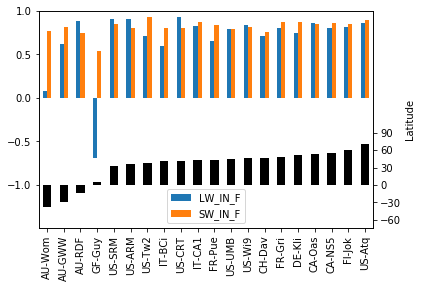

In [111]:
df = pd.merge(perf, meta, left_index=True, right_index=True)

ax = df[['LW_IN_F', 'SW_IN_F']].plot.bar()
ax2 = ax.twinx() 
df.lat.plot.bar(ax=ax2, color='k')
ax.set_ylim(-1.5, 1)
ax.set_yticks(np.arange(-1, 1.1, .5))
ax2.set_ylim(-75, 300)
ax2.set_ylabel('Latitude')
ax2.set_yticks(np.arange(-60, 91, 30))
ax.legend(loc=8)

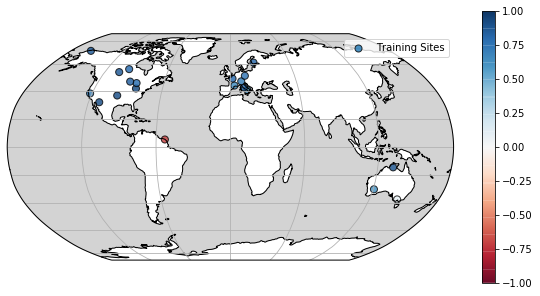

In [76]:
import cartopy
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10,10))


ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.Robinson())
m = ax.scatter(df.lon, df.lat, c=df['LW_IN_F'].values, cmap='RdBu', edgecolors='k',
           transform=ccrs.PlateCarree(), label='Training Sites', vmin=-1, vmax=1, s=50, alpha=0.8)
ax.set_global()
# ax.stock_img()
ax.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='lightgray')
# ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
plt.colorbar(m, shrink=0.5)
# ax.
ax.coastlines()
ax.gridlines()
ax.legend()

In [53]:
ax.scatter?

Signature: ax.scatter(*args, **kwargs)
Docstring:
Add the "transform" keyword to :func:`~matplotlib.pyplot.scatter'.

Other Parameters
----------------
transform
    A :class:`~cartopy.crs.Projection`.
File:      ~/projects/envs/met-ml/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py
Type:      method
